In [1]:
#%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [43]:
from scipy import stats as st

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [6]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

# View the tables that were found with automap
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Explore the tables and find their column names and types

In [9]:
# Initialize the inspector
inspector = inspect(engine)

# Get column names for the Measurement Table
measurement_columns = inspector.get_columns('measurement')

# Use the inspector to print the names in the Measurement Table and its types
for column in measurement_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Get column names for the Measurement Table
station_columns = inspector.get_columns('station')

# Use the inspector to print the names in the Measurement Table and its types
for column in station_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

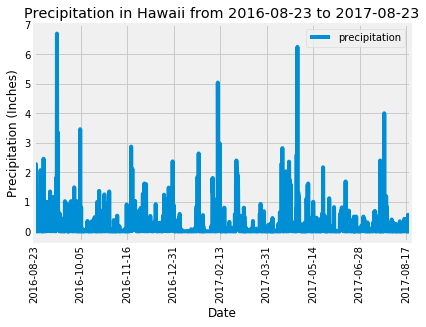

In [145]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

# First get the most current date in the data by querying date column in the Measurement table
most_current = session.query(func.max(Measurement.date)).first()

# Split the date into a list of strings in the following format: [yyyy,mm,dd]
last_date = most_current[0].split('-')

# Calculate the date 1 year ago by subtracting 365 days from the most current date
one_year = dt.date(int(last_date[0]), int(last_date[1]), int(last_date[2])) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
date_prcp_latest_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year)

# Save the query results as a Pandas DataFrame and set the index to the date column, drop NA to clean up the data
precipitation_df = pd.DataFrame(date_prcp_latest_year, columns=["date", "precipitation"]).set_index("date").dropna()

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title=f"Precipitation in Hawaii from {one_year} to {most_current[0]}", rot=90)
plt.ylabel("Precipitation (Inches)")
plt.xlabel("Date",)
plt.xlim(0,len(precipitation_df));

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.station)).first()
station_count

(9)

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Create a selection to pass into the query
min_max_avg = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

# Write out the query, unpack the selection from above, and filter for the most active station ID
most_active_station = session.query(*min_max_avg).\
    filter(Measurement.station == active_stations[0][0]).all()

to_print = np.ravel(most_active_station)

print(f"Most active station ID: {active_stations[0][0]}\n" +
      f"Lowest temperature recorded (F): {to_print[0]:.02f}\n" +
      f"Highest temperature recorded (F): {to_print[1]:.02f}\n" +
      f"Average temperature recorded (F): {to_print[2]:.02f}")

Most active station ID: USC00519281
Lowest temperature recorded (F): 54.00
Highest temperature recorded (F): 85.00
Average temperature recorded (F): 71.66


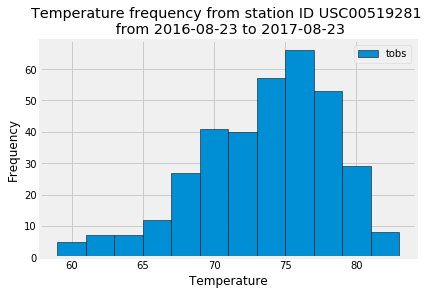

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# First write a query to get all the temperature observations for the most active station over the last year
most_active_station_tobs = session.query(Measurement.tobs).\
    filter(Measurement.station == active_stations[0][0]).\
    filter(Measurement.date >= one_year)

# Create a data frame from the query
tobs_hist = pd.DataFrame(most_active_station_tobs, columns=["tobs"])

# Plot the histogram and add all labels
plt.hist(tobs_hist["tobs"], bins=12, edgecolor='black')
plt.legend(labels=[tobs_hist.columns.values[0]])
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title(f"Temperature frequency from station ID {active_stations[0][0]} \n from {one_year} to {most_current[0]}");

# Bonus Challenge Assignment

## Temperature Analysis I

In [139]:
# Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

# Query the database for date and tobs
june_query = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "06")
june_df = pd.DataFrame(june_query, columns=["Date", "Temperature"])
june = june_df["Temperature"].mean()

december_query = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "12")
december_df = pd.DataFrame(december_query, columns=["Date", "Temperature"])
december = december_df["Temperature"].mean()

print(f"June TAVG: {june},\nDecember TAVG: {december}")

June TAVG: 74.94411764705882,
December TAVG: 71.04152933421226


In [59]:
# Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?
st.ttest_ind(june_df["Temperature"], december_df["Temperature"])

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

### Conclusion for t-test:

We use an unpaired t-test to compare the means because we are looking at two different groups that do not depend on one another.

H0: There is no significance between the difference in means for July and December.
HA: There is significance between the difference in means for July and December.

Since the p-value is well below 0.05, we can reject the null and conclude that there is a significant difference between the average temperature in July and December.

In [125]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [126]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Choose vacation dates
vacation_start = "2017-12-01"
vacation_end = "2017-12-15"

# Find the matching dates from the previous year
previous_year_start = (dt.datetime.strptime(vacation_start, '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
previous_year_end = (dt.datetime.strptime(vacation_end, '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

# Pass the previous years dates to the function to retreive the min, avg, and max temps
vacation = calc_temps(previous_year_start, previous_year_end)

tmin = vacation[0][0]
tavg = vacation[0][1]
tmax = vacation[0][2]

vacation

[(62.0, 70.56122448979592, 78.0)]

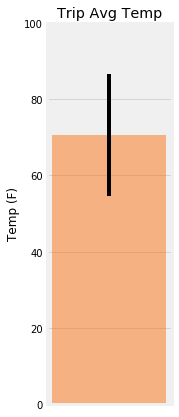

In [122]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2,7))
plt.grid(axis='y', alpha=0.75)
plt.xticks([])
trip_bar = plt.bar(x=" ", height=tavg, yerr=(tmax-tmin), color="#ff6600", alpha=0.45)
plt.ylim(0,100)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)");

In [143]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

search_query = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

rainfall = session.query(*search_query).\
            filter(Measurement.date >= previous_year_start).\
            filter(Measurement.date <= previous_year_end).\
            group_by(Measurement.station).\
            join(Station, Measurement.station == Station.station).\
            order_by(func.sum(Measurement.prcp).desc())

vacation_info = pd.DataFrame(rainfall, columns=["Station ID", "Station Name", "Latitude", "Longitude", "Elevation", "Total Precipitation"])
vacation_info

,Station ID,Station Name,Latitude,Longitude,Elevation,Total Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,6.62
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,3.37
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.89
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.74
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,1.36
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,1.30
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.29


In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [162]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
# These dates are set above as vacation_start and vacation_end

# Use the start and end date to create a range of dates
time_start = dt.datetime.strptime(vacation_start, "%Y-%m-%d")
time_end = dt.datetime.strptime(vacation_end, "%Y-%m-%d")
time_total = time_end - time_start

# Stip off the year and save a list of %m-%d strings
normals = []
for anotha_one in range(time_total.days+1):
    anotha_day = time_start + dt.timedelta(days=anotha_one)
    normals.append(dt.datetime.strftime(anotha_day, '%m-%d'))

# Loop through the list of %m-%d strings and calculate the normals for each date
vacation_normals = []
for days in normals:
    vacation_normals.append(daily_normals(days)[0])
vacation_normals

[(65.0, 71.91666666666667, 78.0),
 (62.0, 71.32692307692308, 77.0),
 (67.0, 72.88679245283019, 79.0),
 (66.0, 72.17647058823529, 81.0),
 (64.0, 70.92156862745098, 78.0),
 (61.0, 69.3921568627451, 78.0),
 (58.0, 69.2, 79.0),
 (60.0, 70.27450980392157, 83.0),
 (64.0, 71.90196078431373, 80.0),
 (61.0, 71.24528301886792, 78.0),
 (64.0, 72.38775510204081, 78.0),
 (64.0, 70.88235294117646, 79.0),
 (65.0, 70.9423076923077, 80.0),
 (65.0, 71.18, 78.0),
 (62.0, 71.34, 79.0)]

In [189]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# Add all current values to dataframe
normals_df = pd.DataFrame(vacation_normals, columns=["Min TOBS", "Avg TOBS", "Max TOBS"])

# Create a list to append the dates to
dates = []

# Loop through the length of the dataframe
# Add a day to the start date
# append the date in YYYY-MM-DD format
for x in range(len(normals_df+1)):
    add_date = time_start + dt.timedelta(days=x)
    dates.append(dt.datetime.strftime(add_date, "%Y-%m-%d"))

normals_df["Date"] = dates
date_index = normals_df.set_index("Date")
date_index

,Min TOBS,Avg TOBS,Max TOBS
Date,,,
2017-12-01,65.0,71.916667,78.0
2017-12-02,62.0,71.326923,77.0
2017-12-03,67.0,72.886792,79.0
2017-12-04,66.0,72.176471,81.0
2017-12-05,64.0,70.921569,78.0
2017-12-06,61.0,69.392157,78.0
2017-12-07,58.0,69.200000,79.0
2017-12-08,60.0,70.274510,83.0
2017-12-09,64.0,71.901961,80.0


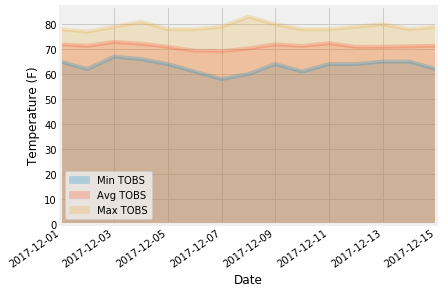

In [205]:
# Plot the daily normals as an area plot with `stacked=False`

date_index.plot(kind="area", stacked=False, rot=35, alpha=.25)
plt.xticks(ha="right")
plt.xlim(0, len(date_index)-1)
plt.ylabel("Temperature (F)")
plt.xlabel("Date");